In [26]:
import pandas as pd
import numpy as np
import json
from scipy.stats import wasserstein_distance

import ast
import math
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def get_country_code_list():
    country_path = "../dataset/country.jsonl"
    json_file = open(country_path)
    country_dict = json.load(json_file)
    return list(country_dict.keys())

country_code_list = get_country_code_list()

In [28]:
llm_list = [
    "CohereLabs/aya-23-35B",
    "meta-llama/Meta-Llama-3-70B-Instruct",
    "Qwen/Qwen2.5-72B-Instruct",
    "gpt-3.5-turbo", 
    "gpt-4", 
    "deepseek-chat",
    "deepseek-reasoner"
]

llm_name_dict = {
    "CohereLabs/aya-23-35B": "Aya23",
    "meta-llama/Meta-Llama-3-70B-Instruct": "Llama3",
    "Qwen/Qwen2.5-72B-Instruct": "Qwen2.5",
    "gpt-3.5-turbo": "GPT-3.5", 
    "gpt-4": "GPT-4", 
    "deepseek-chat": "DS-V3",
    "deepseek-reasoner": "DS-R1"
}

In [29]:
def get_question_dict():
    question_dict= dict()
    lm_data_path = "../results/RQ1/gpt-4/results.csv"
    lm_df = pd.read_csv(lm_data_path)
    lm_df = lm_df[lm_df['type'] == 'Opinion-Dependent']
    for index, row in lm_df.iterrows():
        question_dict[row['id']] = ast.literal_eval(row['choice_keys'])
    return question_dict

In [30]:
question_dict = get_question_dict()

In [31]:
def get_human_distribution_by_question(question_item, human_df):
    human_df = human_df[question_item[0]]
    if human_df.empty:
        return None
    
    human_df = human_df.value_counts().sort_index()

    human_distribution = {}
    is_ok = False
    for c in question_item[1]:
        if int(c) not in human_df.index:
            human_distribution[c] = 0
        else:
            human_distribution[c] = human_df[int(c)]
            is_ok = True
    if not is_ok:
        return None
    human_distribution = {k: float(v / sum(human_distribution.values())) for k, v in human_distribution.items()}
    return human_distribution

In [32]:
def shannon_entropy(p_list, base=2):
    probs = [float(p) for p in p_list if p > 0]
    s = sum(probs)
    if not math.isclose(s, 1.0, rel_tol=1e-9, abs_tol=1e-12):
        probs = [p / s for p in probs]
    log_fn = {2: math.log2, math.e: math.log, 10: math.log10}.get(base, lambda x: math.log(x, base))
    return -sum(p * log_fn(p) for p in probs)

In [33]:
def inconsistency_score(D):
    score_list = []
    for k, v in D.items():
        score =  shannon_entropy([p for p in v.values()], base=2) / math.log(len(v), 2)
    score_list.append(score)
    return np.round(np.mean(score_list), 4)

In [34]:
human_data_path = "../dataset/wvs/WV7.csv"
human_df = pd.read_csv(human_data_path, low_memory=False)

human_od_dict = dict()
for (question_item) in question_dict.items():
    human_distribution = get_human_distribution_by_question(question_item, human_df)
    if human_distribution is None:
        continue
    human_od_dict[question_item[0]] = human_distribution

consistency = inconsistency_score(human_od_dict)

In [35]:
consistency

np.float64(0.9449)

In [36]:
def get_human_distribution_by_country_and_question(country_code, question_item, human_df):
    human_df = human_df[human_df['B_COUNTRY'] == int(country_code)][question_item[0]]
    if human_df.empty:
        return None
    
    human_df = human_df.value_counts().sort_index()

    human_distribution = {}
    is_ok = False
    for c in question_item[1]:
        if int(c) not in human_df.index:
            human_distribution[c] = 0
        else:
            human_distribution[c] = human_df[int(c)]
            is_ok = True
    if not is_ok:
        return None
    human_distribution = {k: float(v / sum(human_distribution.values())) for k, v in human_distribution.items()}
    return human_distribution

In [37]:
country_code_od_dict = dict()
for country_code in country_code_list:
    country_od_dict = dict()
    for (question_item) in question_dict.items():
        llm_distribution = get_human_distribution_by_country_and_question(country_code, question_item, human_df)
        if llm_distribution is None:
            continue
        country_od_dict[question_item[0]] = llm_distribution
    if len(country_od_dict) == 0:
        continue
    country_code_od_dict[country_code] = country_od_dict

In [38]:
def get_llm_distribution_by_country_and_question(question_item, llm_df):
    llm_distribution_rough = llm_df[llm_df['id'] == question_item[0]]['response'].values[0]
    try:
        prob_dict = ast.literal_eval(llm_distribution_rough)
    except:
        llm_distribution_rough = re.sub(r'(\d+):\s*([\d.]+%)', r"'\1': '\2'", llm_distribution_rough)
        prob_dict = ast.literal_eval(llm_distribution_rough)

    llm_distribution = {k: float(v.strip('%')) / 100 for k, v in prob_dict.items()}
    return llm_distribution

In [39]:
def alignment_score_max_min(D1, D2, Q):
    scores = []
    for q in Q:
        if q not in D1 or q not in D2:
            continue
        
        p1 = D1[q]
        p2 = D2[q]

        if len(p1) != len(p2):
            continue
        N = len(p1) 
        support = np.array([int(k) for k, v in sorted(p1.items())])
        wd = wasserstein_distance(support, support, [v for k, v in sorted(p1.items())], [v for k, v in sorted(p2.items())])
        score = 1 - wd / (N - 1)
        scores.append(score)
    return np.round(np.mean(scores), 4), np.round(np.max(scores), 4), np.round(np.min(scores), 4)

In [40]:
def alignment_score(D1, D2, Q):
    scores = []
    for q in Q:
        if q not in D1 or q not in D2:
            continue
        
        p1 = D1[q]
        p2 = D2[q]

        if len(p1) != len(p2):
            continue
        N = len(p1) 
        support = np.array([int(k) for k, v in sorted(p1.items())])
        wd = wasserstein_distance(support, support, [v for k, v in sorted(p1.items())], [v for k, v in sorted(p2.items())])
        score = 1 - wd / (N - 1)
        scores.append(score)
    return np.round(np.mean(scores), 4)

In [41]:
llm_data_list = []
for llm in llm_list:
    llm_data_path = f"../results/RQ1/{llm}/results.csv"
    llm_df = pd.read_csv(llm_data_path)
    llm_df = llm_df[llm_df['type'] == 'Opinion-Dependent']

    llm_od_dict = dict()
    for (question_item) in question_dict.items():
        if question_item[0] in ["Q60", "Q70", "Q90", "Q110", "Q130"]:
            continue
        llm_distribution = get_llm_distribution_by_country_and_question(question_item, llm_df)
        if llm_distribution is None:
            continue
        llm_od_dict[question_item[0]] = llm_distribution

    
    score, score_max, score_min = alignment_score_max_min(human_od_dict, llm_od_dict, question_dict.keys())
    consistency = inconsistency_score(llm_od_dict)
    print(f"{llm} score: {np.round(score, 4)}")
    print(f"{llm} max: {np.round(score_max - score, 4)}")
    print(f"{llm} min: {np.round(score - score_min, 4)}")
    print(f"{llm} consistency: {np.round(consistency, 4)}")

    for country_code in country_code_list:
        if country_code_od_dict.get(country_code) is None:
            continue
        country_od_dict = country_code_od_dict[country_code]
        score = alignment_score(llm_od_dict, country_od_dict, question_dict.keys())
        llm_data_list.append([llm_name_dict[llm], np.round(score, 4)])

CohereLabs/aya-23-35B score: 0.8664
CohereLabs/aya-23-35B max: 0.1255
CohereLabs/aya-23-35B min: 0.3017
CohereLabs/aya-23-35B consistency: 0.9614
meta-llama/Meta-Llama-3-70B-Instruct score: 0.8853
meta-llama/Meta-Llama-3-70B-Instruct max: 0.1114
meta-llama/Meta-Llama-3-70B-Instruct min: 0.2546
meta-llama/Meta-Llama-3-70B-Instruct consistency: 0.8433
Qwen/Qwen2.5-72B-Instruct score: 0.9016
Qwen/Qwen2.5-72B-Instruct max: 0.0974
Qwen/Qwen2.5-72B-Instruct min: 0.4656
Qwen/Qwen2.5-72B-Instruct consistency: 0.9545
gpt-3.5-turbo score: 0.8606
gpt-3.5-turbo max: 0.1271
gpt-3.5-turbo min: 0.4177
gpt-3.5-turbo consistency: 0.9197
gpt-4 score: 0.8932
gpt-4 max: 0.0859
gpt-4 min: 0.4303
gpt-4 consistency: 0.8587
deepseek-chat score: 0.8879
deepseek-chat max: 0.112
deepseek-chat min: 0.3678
deepseek-chat consistency: 0.928
deepseek-reasoner score: 0.9091
deepseek-reasoner max: 0.0878
deepseek-reasoner min: 0.1815
deepseek-reasoner consistency: 0.7799


In [42]:
llms_df = pd.DataFrame(llm_data_list, columns=['llm', 'score'])

_group_means = llms_df.groupby('llm')['score'].mean()

group_means = {}
for llm_name in llm_name_dict.values():
    group_means[llm_name] = _group_means[llm_name]

/home/yangliu/anaconda3/envs/l/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yangliu/anaconda3/envs/l/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


{'Aya23': np.float64(0.8198075757575758), 'Llama3': np.float64(0.8376848484848485), 'Qwen2.5': np.float64(0.8461666666666667), 'GPT-3.5': np.float64(0.8122378787878788), 'GPT-4': np.float64(0.8406954545454546), 'DS-V3': np.float64(0.8323515151515152), 'DS-R1': np.float64(0.8530363636363637)}


/home/yangliu/anaconda3/envs/l/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


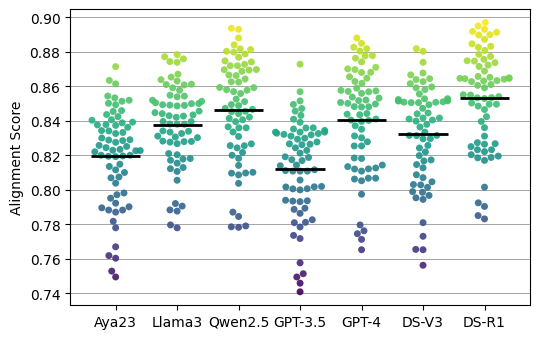

In [48]:
plt.figure(figsize=(5.5, 3.5))
ax = sns.swarmplot(
    x="llm", 
    y="score", 
    data=llms_df, 
    hue="score",
    legend=False,
    alpha=0.9, 
    palette="viridis", 
    zorder=8,
    linewidth=0.0,
    size=5)

print(group_means)
for i, (llm, mean) in enumerate(group_means.items()):
    ax.hlines(mean, i - 0.4, i + 0.4, color='k', lw=2, zorder=10)


plt.xlabel("")
plt.ylabel("Alignment Score")
plt.grid(axis='y',color='grey', linewidth=0.5)
plt.tight_layout()
plt.savefig("../figures/RQ1/compare_llms.pdf",dpi=300)